<a href="https://colab.research.google.com/github/jeffth-lu/HGraph/blob/master/CovidCXR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# check GPU infomation
!nvidia-smi

Wed Apr 27 13:52:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## ~匯入所有需要的套件模組

In [ ]:
import os, glob, shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# tensorflow.keras
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers, initializers, regularizers, optimizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

# evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.signal import resample
from scipy import interp
from itertools import cycle, product

Tensorflow version = 2.8.0


# 準備資料集  
In total, there are 21165 samples divided into four main classes:

Covid-19
Lung Opacity
Normal
Viral Pneumonia
All the images are in Portable Network Graphics (PNG) file format and the resolution are 299x299 pixels. On this current update, the database currently holds 3,616 COVID-19 positive cases, 10,192 Normal, 6,012 Lung Opacity (Non-COVID lung infection), and 1,345 Viral Pneumonia images.

In [ ]:
#@title 下載並解壓縮 資料集
#@markdown 來源: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
!pip install -q --upgrade --no-cache-dir gdown
!gdown --id 1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
!unzip -n -q 'COVID-19_Radiography_Database_old.zip' -d .
print("... done")

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database_old.zip
100% 780M/780M [00:08<00:00, 93.7MB/s]
... done


In [ ]:
# 指定資料的目錄
data_root = "COVID-19_Radiography_Dataset"

## 標記分析

In [ ]:
# 分類數量分析
C0_files = glob.glob(data_root + "/COVID/*.png")
C1_files = glob.glob(data_root + "/Lung_Opacity/*.png")
C2_files = glob.glob(data_root + "/Normal/*.png")
C3_files = glob.glob(data_root + "/Viral Pneumonia/*.png")
print("COVID:", len(C0_files))
print("Lung_Opacity:", len(C1_files))
print("Normal:", len(C2_files))
print("Viral Pneumonia:", len(C3_files))

COVID: 3616
Lung_Opacity: 6012
Normal: 10192
Viral Pneumonia: 1345


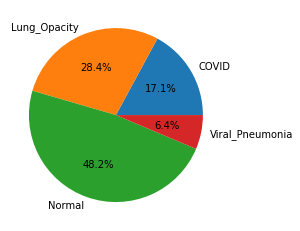

In [ ]:
# 各標記數量 畫成 圓餅圖(pie chart)
CLASSES = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
plt.pie([len(C0_files), len(C1_files), len(C2_files), len(C3_files)], labels=CLASSES, autopct='%1.1f%%')
plt.show()

# 分割驗證集 (validation set)

In [ ]:
# 取得 1/5 的檔案列表
C0_files_train, C0_files_test = train_test_split(C0_files, test_size=0.2, random_state=33)
C1_files_train, C1_files_test = train_test_split(C1_files, test_size=0.2, random_state=33)
C2_files_train, C2_files_test = train_test_split(C2_files, test_size=0.2, random_state=33)
C3_files_train, C3_files_test = train_test_split(C3_files, test_size=0.2, random_state=33)
print(f"C0 train/valid = {len(C0_files_train)} / {len(C0_files_test)}")
print(f"C1 train/valid = {len(C1_files_train)} / {len(C1_files_test)}")
print(f"C2 train/valid = {len(C2_files_train)} / {len(C2_files_test)}")
print(f"C3 train/valid = {len(C3_files_train)} / {len(C3_files_test)}")

C0 train/valid = 2892 / 724
C1 train/valid = 4809 / 1203
C2 train/valid = 8153 / 2039
C3 train/valid = 1076 / 269


In [ ]:
# 一個檔案路徑 長這樣
print("file path :", C3_files_test[0])
print("file dir :", os.path.dirname(C3_files_test[0]))

file path : COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-721.png
file dir : COVID-19_Radiography_Dataset/Viral Pneumonia


In [ ]:
# 移動 1/5 的驗證檔案
for f in C0_files_test + C1_files_test + C2_files_test + C3_files_test:
    target_f = f.replace('COVID-19_Radiography_Dataset', 'COVID-19_Radiography_Dataset_valid')
    os.makedirs(os.path.dirname(target_f), exist_ok=True)  # 如果目標資料夾不在，就建立一個
    shutil.move(f, target_f)
    print('.', end="")
print("\nValid data moved !")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## 圖像分析

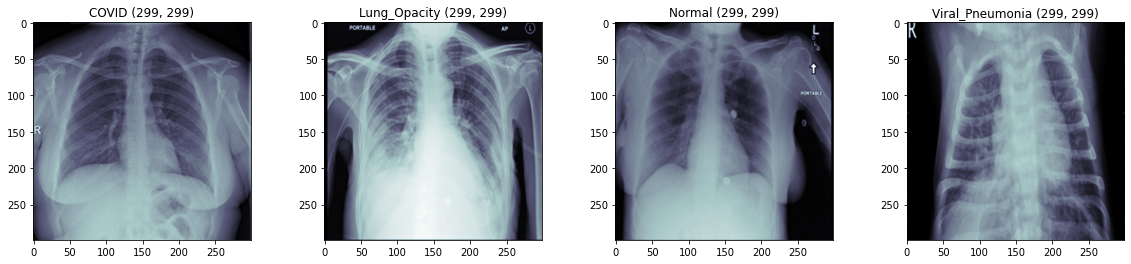

In [ ]:
#@title random show images 
plt.figure(figsize=(20,4))

# random plot COVID images
i = np.random.randint(low=0, high=1000)
image_arr = np.asarray(Image.open(C0_files_train[i]))  # open an image as np arr
plt.subplot(141)
plt.title(f"COVID {image_arr.shape}")
plt.imshow(image_arr, cmap='bone')

# random plot Lung_Opacity images
i = np.random.randint(low=0, high=1000)
image_arr = np.asarray(Image.open(C1_files_train[i]))  # open an image as np arr
plt.subplot(142)
plt.title(f"Lung_Opacity {image_arr.shape}")
plt.imshow(image_arr, cmap='bone')

# random plot Normal images
i = np.random.randint(low=0, high=1000)
image_arr = np.asarray(Image.open(C2_files_train[i]))  # open an image as np arr
plt.subplot(143)
plt.title(f"Normal {image_arr.shape}")
plt.imshow(image_arr, cmap='bone')

# random plot Viral_Pneumonia images
i = np.random.randint(low=0, high=1000)
image_arr = np.asarray(Image.open(C3_files_train[i]))  # open an image as np arr
plt.subplot(144)
plt.title(f"Viral_Pneumonia {image_arr.shape}")
plt.imshow(image_arr, cmap='bone')

plt.show()

# 資料生成器準備

In [ ]:
#@title 影像擴增設定
#@markdown https://keras.io/preprocessing/image/

shear_range = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}
fill_mode = 'constant' #@param ['constant', 'nearest', 'reflect', 'wrap']

In [ ]:
#@title 建立生成器
BATCH_SIZE = 16  # 批次大小
IMAGE_SIZE = (299, 299)  # 目標影像大小

# 訓練資料生成器
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip, 
    fill_mode=fill_mode, 
    ) 
train_generator = train_datagen.flow_from_directory(data_root, 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='grayscale',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)

# 驗證資料生成器 (without augmentation)
valid_datagen   = ImageDataGenerator(
    rescale=1./255, 
    )
valid_generator = valid_datagen.flow_from_directory(data_root + "_valid", 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='grayscale',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 16930 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


CLASSES: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
X_batch shape: (16, 299, 299, 1) 	y_batch shape: (16, 4)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


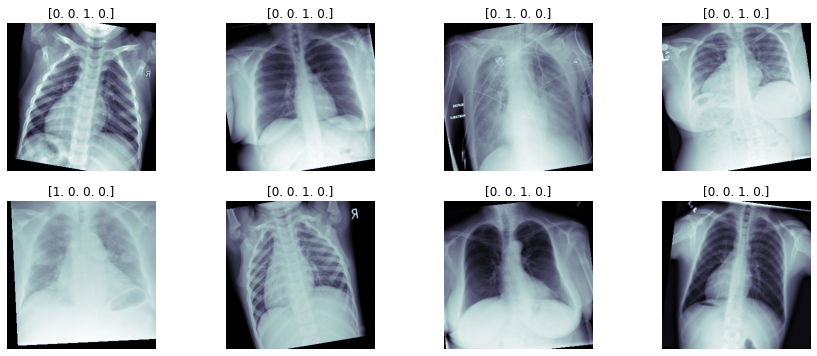

In [ ]:
#@title 視覺化檢查一些訓練影像
CLASSES = list(train_generator.class_indices.keys())
print("CLASSES:", CLASSES)

X_batch, y_batch = train_generator.next()
print("X_batch shape:", X_batch.shape, "\ty_batch shape:", y_batch.shape)

fig=plt.figure(figsize=(15, 6))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X_batch[i-1]
    fig.add_subplot(rows, columns, i)
    plt.title(y_batch[i-1])
    plt.axis('off')
    plt.imshow(img[:,:,0], cmap='bone')
plt.show()

# 模型 model design

In [ ]:
def build_model():
    inputs = layers.Input((299, 299, 1))

    x = layers.Conv2D(filters=32, kernel_size=(3,3))(inputs)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3))(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3))(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=32, activation='relu')(x)
    output = layers.Dense(units=4, activation='softmax')(x)

    # Define the model.
    model = Model(inputs, output, name="C32_mp_relu_x7-GAP-D32-D4")
    return model

# Build model.
K.clear_session()
model = build_model()

# model compile
opti = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opti,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "C32_mp_relu_x7-GAP-D32-D4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                     

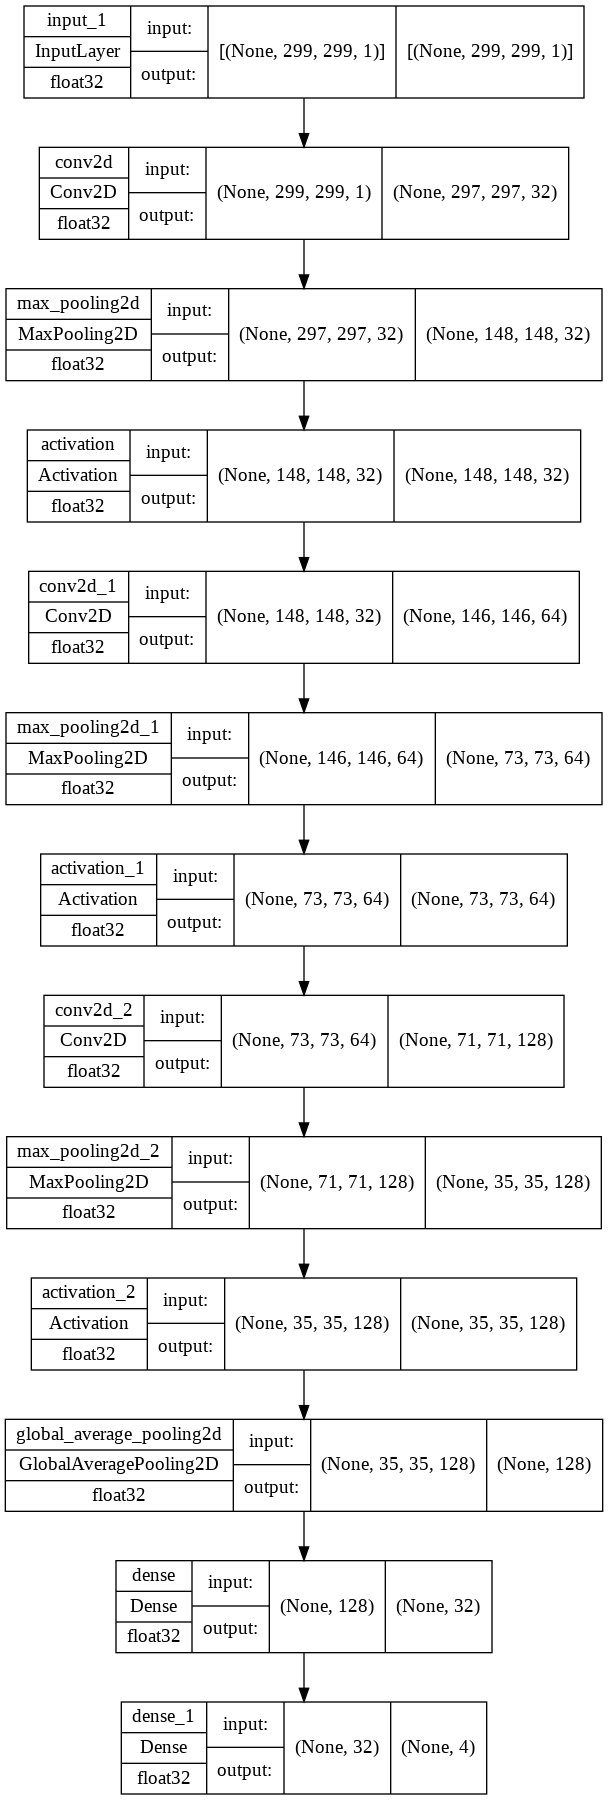

In [ ]:
# 看看設計架構
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

# 訓練 training

In [ ]:
# training  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
EPOCHS = 5

history = model.fit(train_generator,  # < 訓練集產生器
                    epochs=EPOCHS, 
                    validation_data=valid_generator,   # < 驗證集產生器
                    )

Epoch 1/5
1059/1059 [==============================] - 187s 165ms/step - loss: 1.1679 - accuracy: 0.4829 - val_loss: 1.1583 - val_accuracy: 0.5421
Epoch 2/5
1059/1059 [==============================] - 172s 162ms/step - loss: 1.0723 - accuracy: 0.5357 - val_loss: 1.1040 - val_accuracy: 0.5636
Epoch 3/5
1059/1059 [==============================] - 170s 161ms/step - loss: 0.9781 - accuracy: 0.5848 - val_loss: 0.9825 - val_accuracy: 0.6135
Epoch 4/5
1059/1059 [==============================] - 170s 161ms/step - loss: 0.9142 - accuracy: 0.6226 - val_loss: 1.0281 - val_accuracy: 0.6094
Epoch 5/5
1059/1059 [==============================] - 171s 161ms/step - loss: 0.8633 - accuracy: 0.6394 - val_loss: 0.8964 - val_accuracy: 0.6399


In [ ]:
# The history.history attribute is a dictionary
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

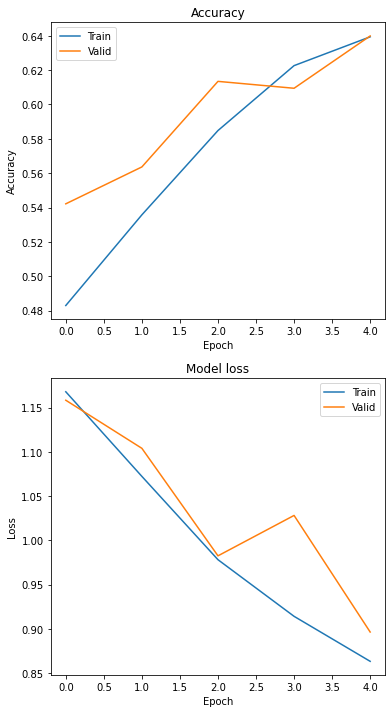

In [ ]:
#@title 訓練曲線
# Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

# plt.savefig('train_history.png', dpi=96)  # <-- save plot
plt.show()

In [ ]:
#@title 儲存模型 save model
h5_file_path = "model.h5"
model.save(h5_file_path)

# 4 評估模型 evaluatiion

In [ ]:
#@title 讀取模型存檔
model = load_model('model.h5')
model.trainable = False

In [ ]:
#@title 準備測試資料
# 重新初始化 valid_generator
valid_generator = valid_datagen.flow_from_directory(data_root + "_valid", 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='grayscale',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=False)

# 取得正確答案 (y_test)
CLASSES = list(valid_generator.class_indices.keys())
y_true = valid_generator.labels
y_true = to_categorical(y_true)  # as one-hot encoding

print("CLASSES:", CLASSES)
print("y_true:", y_true.shape)
print(y_true)

Found 4235 images belonging to 4 classes.
CLASSES: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
y_true: (4235, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
#@title 開始預測
y_pred = model.predict(valid_generator, verbose=1)

print("y_pred shape =", y_pred.shape)
np.set_printoptions(precision=4, suppress=True)
print(y_pred)

265/265 [==============================] - 12s 46ms/step
y_pred shape = (4235, 4)
[[0.2826 0.3634 0.2195 0.1346]
 [0.3892 0.1382 0.4702 0.0023]
 [0.3338 0.2128 0.3417 0.1117]
 ...
 [0.0847 0.1862 0.1894 0.5397]
 [0.1367 0.075  0.5297 0.2586]
 [0.2022 0.1074 0.2508 0.4395]]


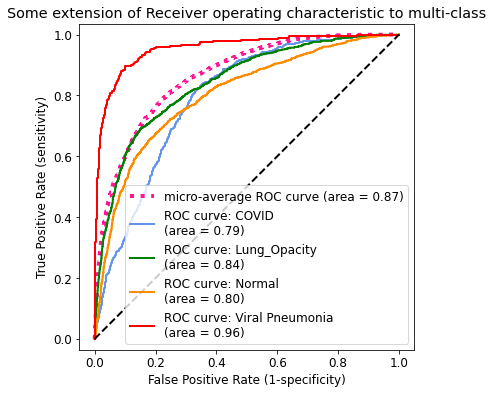

In [ ]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = False  #@param {type:"boolean"}

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
lw = 2
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # 計算 微觀平均曲線
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # 計算 宏觀平均曲線
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

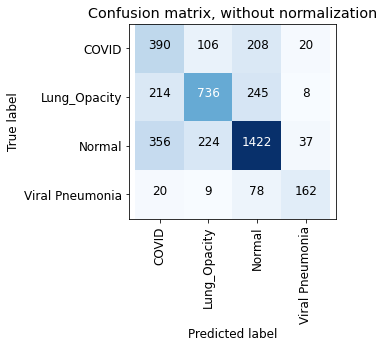

<Figure size 432x288 with 0 Axes>

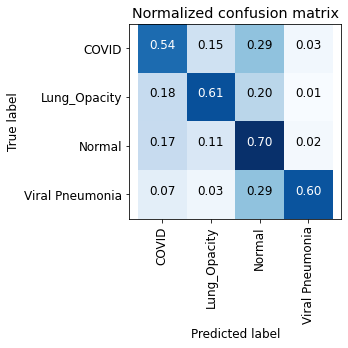

In [ ]:
#@title 畫出 混淆矩陣 confusion matrix
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
#@title 多分類報告 classification report
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report

print(classification_report(y_true.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=CLASSES))

                 precision    recall  f1-score   support

          COVID       0.40      0.54      0.46       724
   Lung_Opacity       0.68      0.61      0.65      1203
         Normal       0.73      0.70      0.71      2039
Viral Pneumonia       0.71      0.60      0.65       269

       accuracy                           0.64      4235
      macro avg       0.63      0.61      0.62      4235
   weighted avg       0.66      0.64      0.65      4235

